In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

from pythia.timeseries.lombscargle import LS_periodogram

In [118]:
# Un-comment this if you want to use lightkurve to get your data
# search = lk.search_lightcurve('U Gru', cadence=120)
# lc = search[-1].download().remove_nans().remove_outliers().normalize()
# time = lc.time.value
# flux = lc.flux.value

# Otherwise, this is much quicker
time, flux = np.loadtxt('../data/ugru.dat').T

Let's take a look at the raw data

<IPython.core.display.Javascript object>


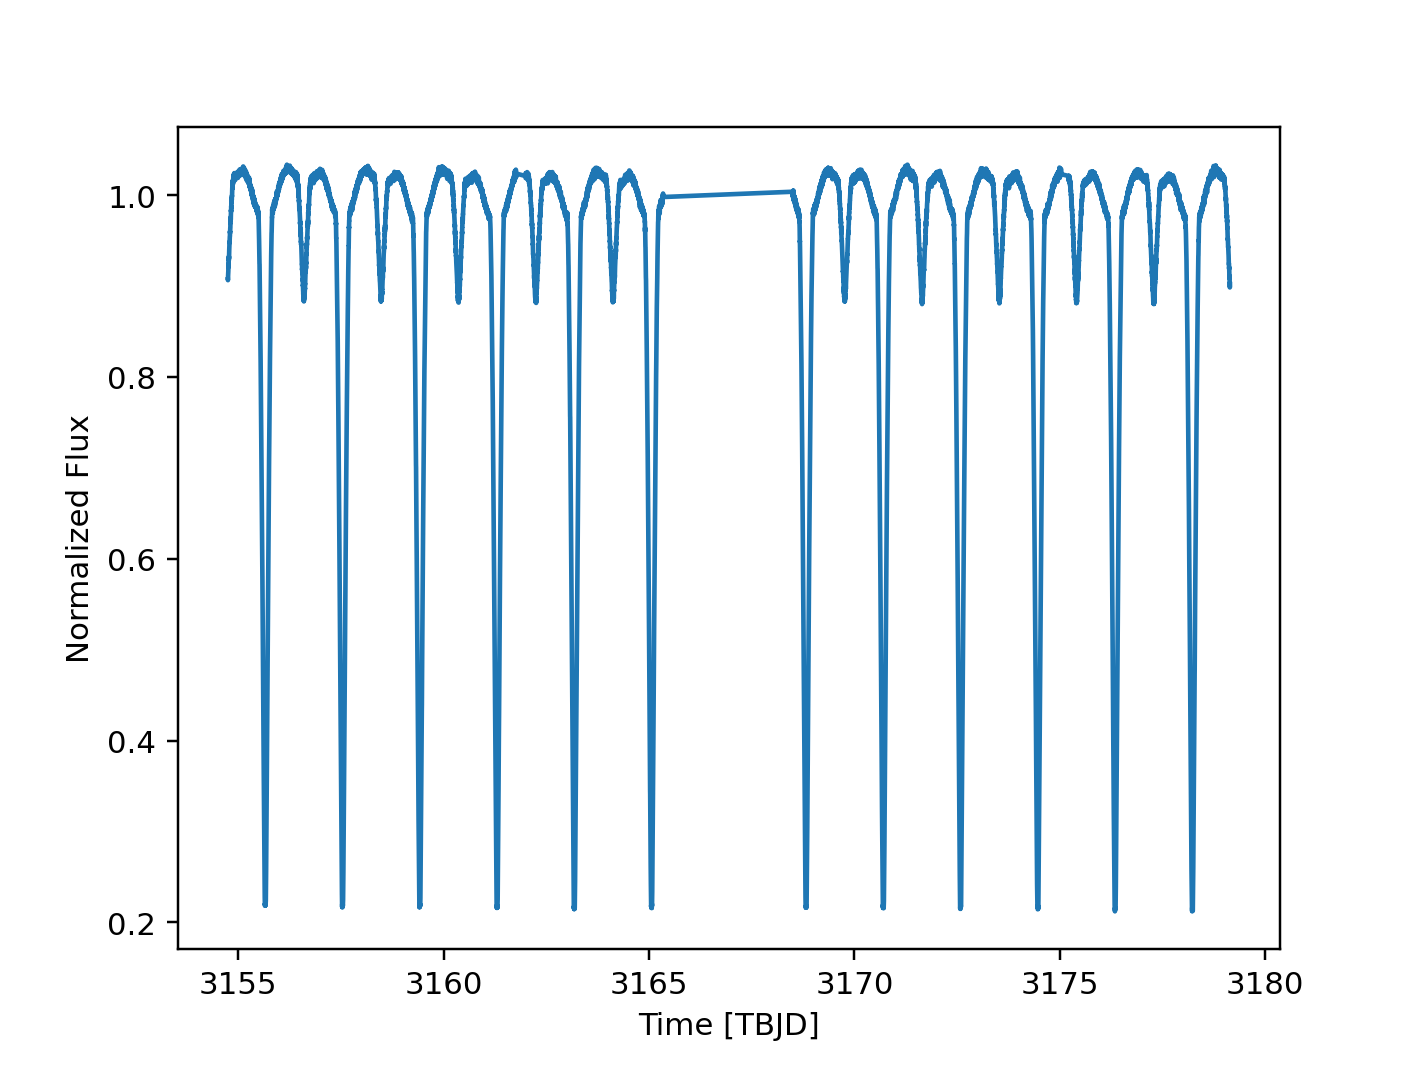

Text(0, 0.5, 'Normalized Flux')

In [119]:
fig_lc, ax_lc = plt.subplots(num=1)
ax_lc.plot(time, flux)
ax_lc.set_xlabel('Time [TBJD]')
ax_lc.set_ylabel('Normalized Flux')

And now let's look at the periodogram

<IPython.core.display.Javascript object>


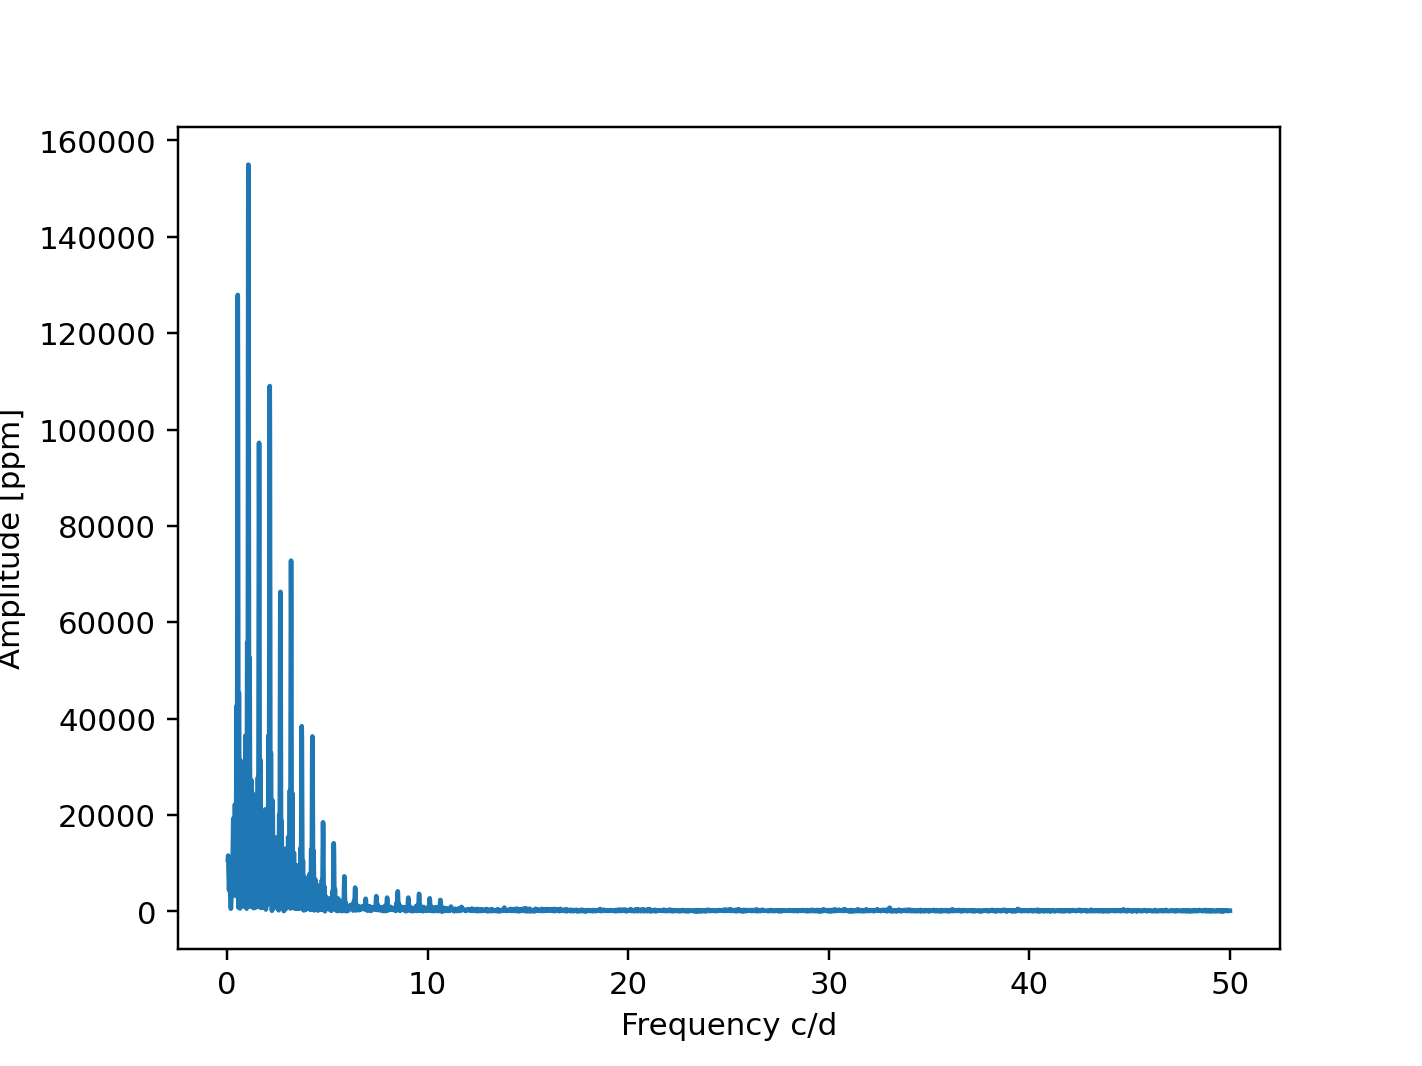

Text(0, 0.5, 'Amplitude [ppm]')

In [54]:
nu, amp = LS_periodogram(time, flux-np.median(flux), max=50)
fig, ax = plt.subplots(num=2)
ax.plot(nu, amp*1e6)
ax.set_xlabel('Frequency c/d')
ax.set_ylabel('Amplitude [ppm]')

Good - we can't see anything except for harmoinics. 
This is exactly what we want to fix!

Below, we have some functions that create a design matrix
with a Fourier basis and we use that to solve for a linear
model that predicts the sum-total of the binary behaviour 
that is described by a harmonic series.

In [120]:
period = 1.88045

In [121]:
def design_matrix(x, period, n_harmonics):

    # We're going to do this as a fourier series, so our design matrix
    # necessarily needs to be the (1 cos() sin()) pairs for each
    # harmonic of the orbital period that we're considering

    # First, we're going to get all the possible cyclic frequencies
    # that we're concerned with, i.e. the N harmonics of the orbital
    # frequency
    omegas = 2. * np.pi * np.arange(1, n_harmonics + 1) / period

    # Next, we instantiate the design matrix to have 2 * n_harmonics + 1 columns
    # since we want an offset term and sin+cos term for each harmonic
    X = np.ones((len(x), 2 * n_harmonics + 1))

    # We do the same to keep track of the actual frequencies in case we
    # want to do the approximate GP regression
    omega_list = np.zeros(2 * n_harmonics + 1)


    # Consider the 0-frequency base term
    #X[:,0] = 1.
    omega_list[0] = 0.

    # Populate the cosine terms
    X[:,1::2] = np.cos(omegas[None, :] * x[:, None]) # I'm dyin heah ## original hogg quote, will not be removing.
    omega_list[1::2] = omegas

    # Populate the cosine terms
    X[:,2::2] = np.sin(omegas[None, :] * x[:, None])
    omega_list[2::2] = omegas

    return X, omega_list


def solve_ridgeRegression(x, y, period, K, alpha, weighted=False, weights=None):
    X,_ = design_matrix(x, period, K)
#     wI = np.eye(X.shape[1])
#     wI[0,0] = 0
#     betas = np.linalg.solve( alpha*wI + X.T@X, X.T @ y)

    if weighted:
        Cinv = np.linalg.inv(np.diag(weights))
        A = X.T@Cinv@X
        B = X.T@Cinv@y
    else:
        A = X.T@X
        B = X.T@y
        
    idd = np.diag_indices_from(A)
    A[idd] += alpha
    
    betas = np.linalg.solve(A, B)
    return betas


def solve_approxGP(x, y, period, K, alpha, width=None, weighted=False, weights=None):

    if width is None:
        width = 0.1*period / (2.*np.pi)
    else:
        width /= (2. * np.pi)

    
    ## Assumes the approximation of a periodic version of the Matern 3/2 kernal
    X,diag_omegas = design_matrix(x, period, K)
    
    # Implement eq. 23 from https://arxiv.org/pdf/2101.07256
    # In this case, we're going to use the same X for our predictions
    # however, we could propose a new X* where we want to predict
    # the regression at times t*
    if weighted:
        Cinv = np.linalg.inv(np.diag(weights))
        A = X.T@Cinv@X
        B = X.T@Cinv@y
    else:
        A = X.T@X
        B = X.T@y
    
    idd = np.diag_indices_from(A)
    A[idd] += alpha * ( (width**2) * (diag_omegas**2) + 1 )
    betas = np.linalg.solve( A, B)
    return betas

def solve_simple(x, y, period, K, weighted=False, weights=None):

    X,_ = design_matrix(x, period, K)
    betas = np.linalg.solve(X.T @ X, X.T @ y)
    # amps, resids, rank, S = np.linalg.lstsq(X, flux, rcond=None)

    return betas

In [111]:
K = 150

X,_ = design_matrix(time, period, K)

# Do this with a simple linear regression
amps = solve_simple(time, flux, period, K)

# Now, let's try a Ridge Regression because why not
amps_rr = solve_ridgeRegression(time, flux, period, K, 10)

# We can also do this 
amps_gp = solve_approxGP(time, flux, period, K, 1)

In [112]:
# Reconstruct the predicted flux based on our linear models
predicted_flux = X @ amps
predicted_flux_rr = X @ amps_rr
predicted_flux_gp = X @ amps_gp

resid = flux - predicted_flux
resid_rr = flux - predicted_flux_rr
resid_gp = flux - predicted_flux_gp

In [113]:
# Now we want to calculate a periodogram of the residuals and see
# if we can identify any new features (i.e., pulsations) that 
# were previously hiding under the harmonic forest from the binary

nu, amp = LS_periodogram(time, resid-np.median(resid), max=50)
nu_rr, amp_rr = LS_periodogram(time, resid_rr-np.median(resid_rr), max=50)
nu_gp, amp_gp = LS_periodogram(time, resid_gp-np.median(resid_gp), max=50)


<IPython.core.display.Javascript object>


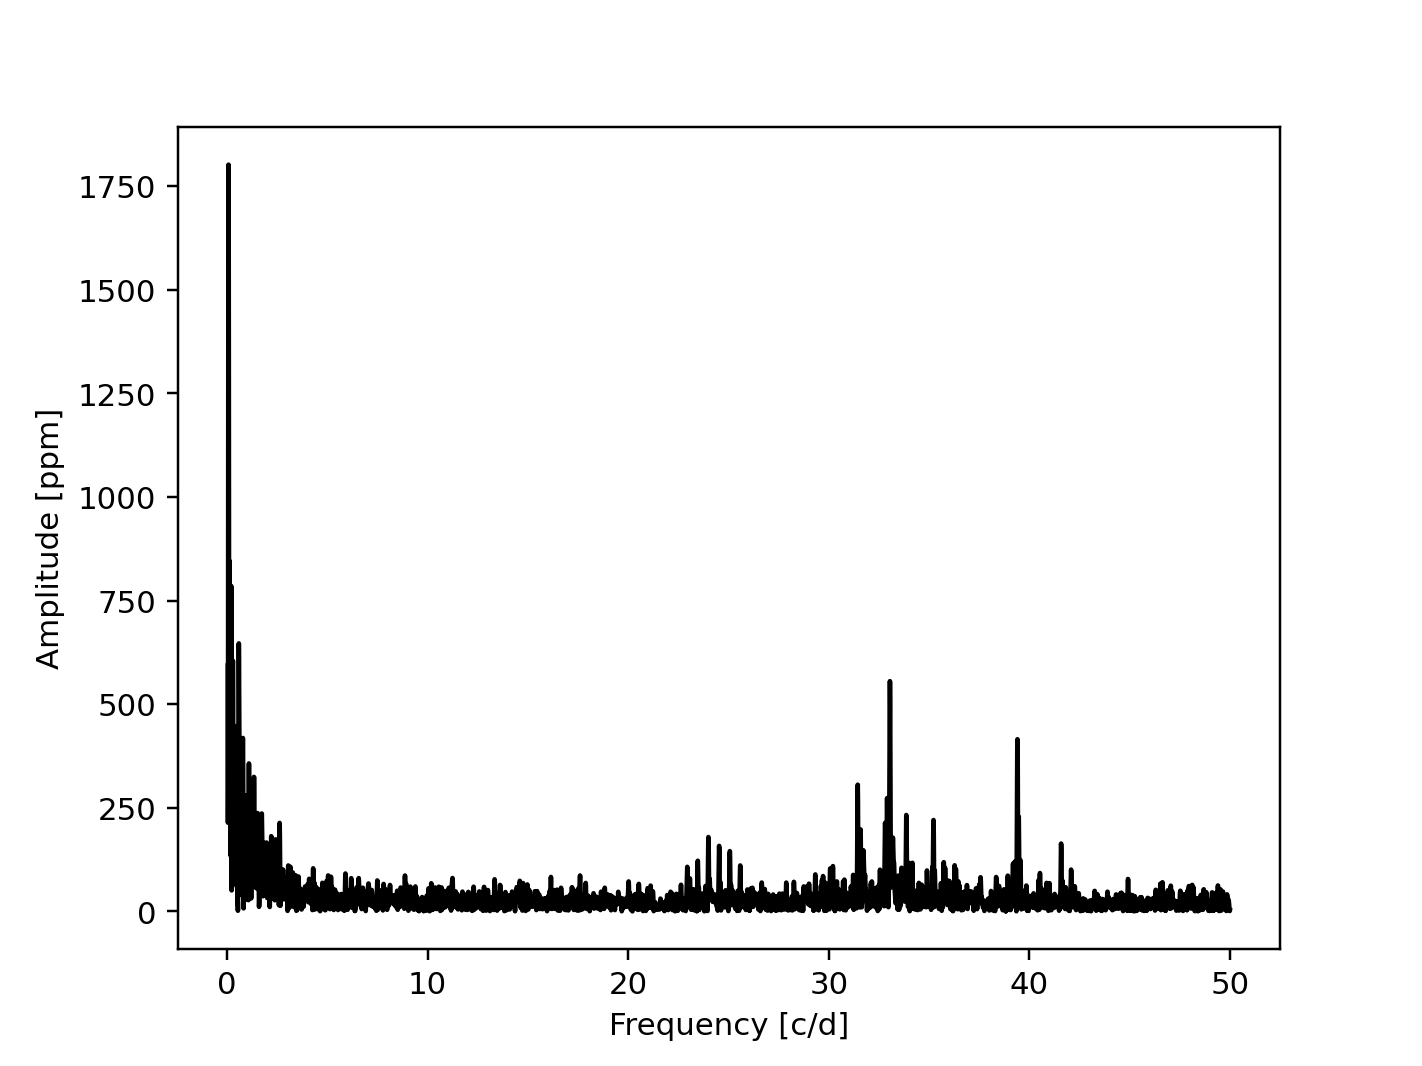

Text(0, 0.5, 'Amplitude [ppm]')

In [115]:
fig_, ax_ = plt.subplots(num=7)
# ax_.plot(nu, amp*1e6, 'k')
# ax_.plot(nu_rr, amp_rr*1e6, 'k')
ax_.plot(nu_gp, amp_gp*1e6, 'k')
ax_.set_xlabel('Frequency [c/d]')
ax_.set_ylabel('Amplitude [ppm]')


So, we see something - but it's not perfect. There is still a lot of residual power in harmonics of the binary frequency, but both the simple
linear regression and the Ridge Regression give the same answer. 

We might have to get creative with improving this. Is the problem in the sharp features around eclipse?

<IPython.core.display.Javascript object>


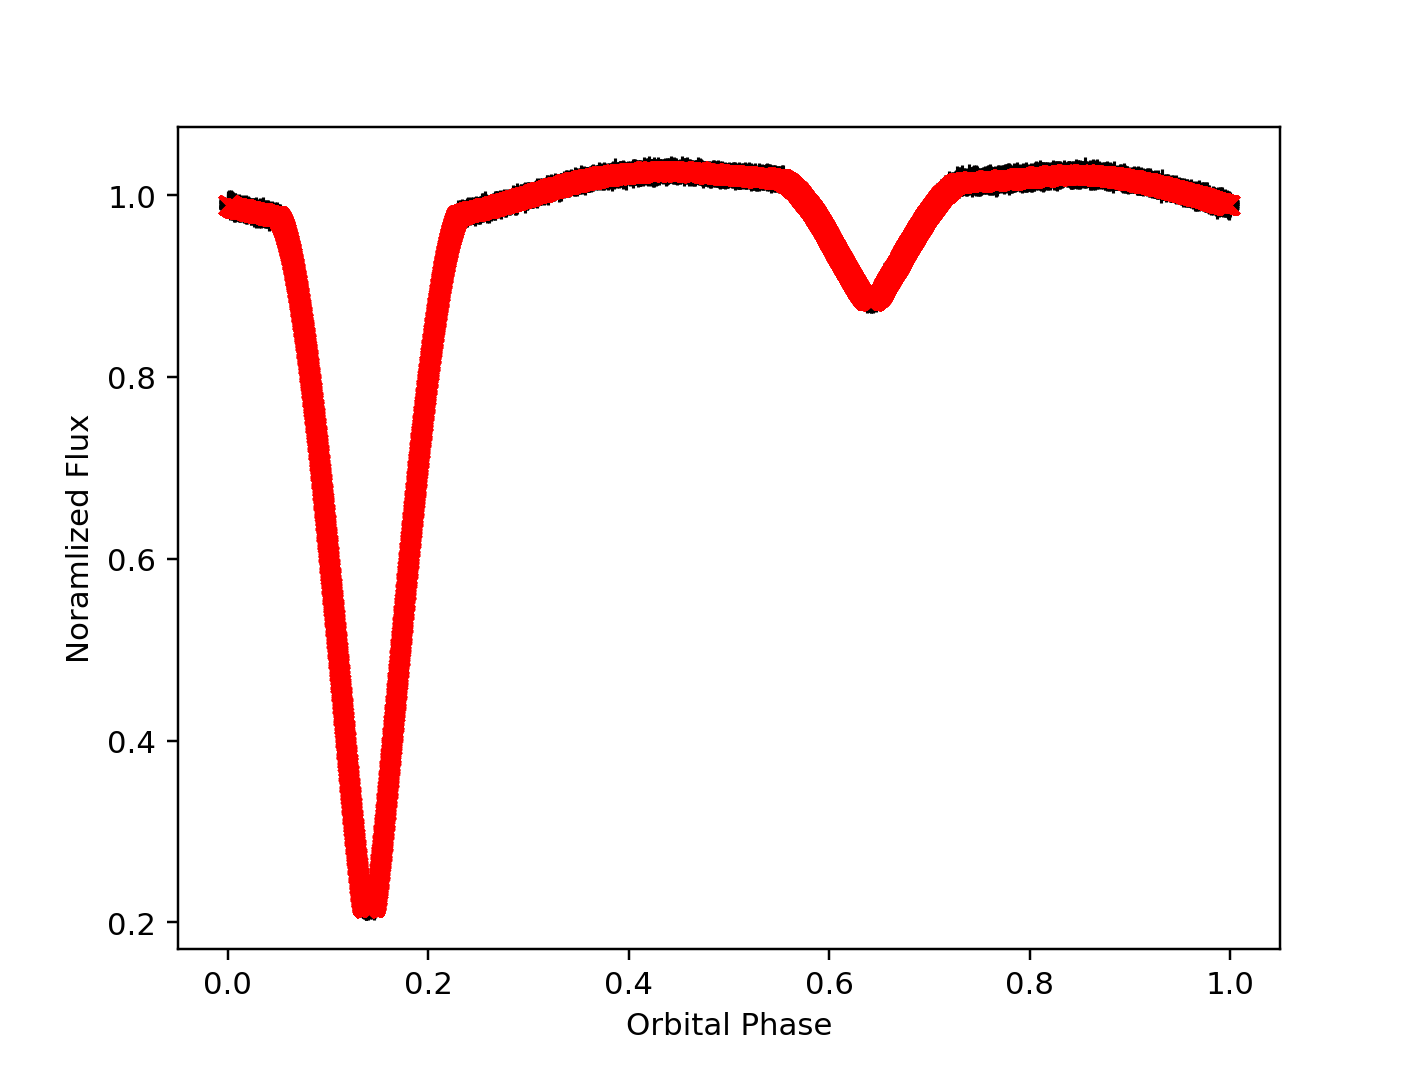

Text(0, 0.5, 'Noramlized Flux')

In [122]:
fig_, ax_ = plt.subplots(num=8)
ph = (time/period)%1
# ax_.plot(ph, predicted_flux-predicted_flux_rr, 'kx')
ax_.plot(ph, flux, 'k+')
ax_.plot(ph, predicted_flux_gp, 'rx')
ax_.set_xlabel('Orbital Phase')
ax_.set_ylabel('Noramlized Flux')